In [1]:
# Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score
from tqdm import tqdm


In [2]:
# load dataset
df_train = pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

In [3]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


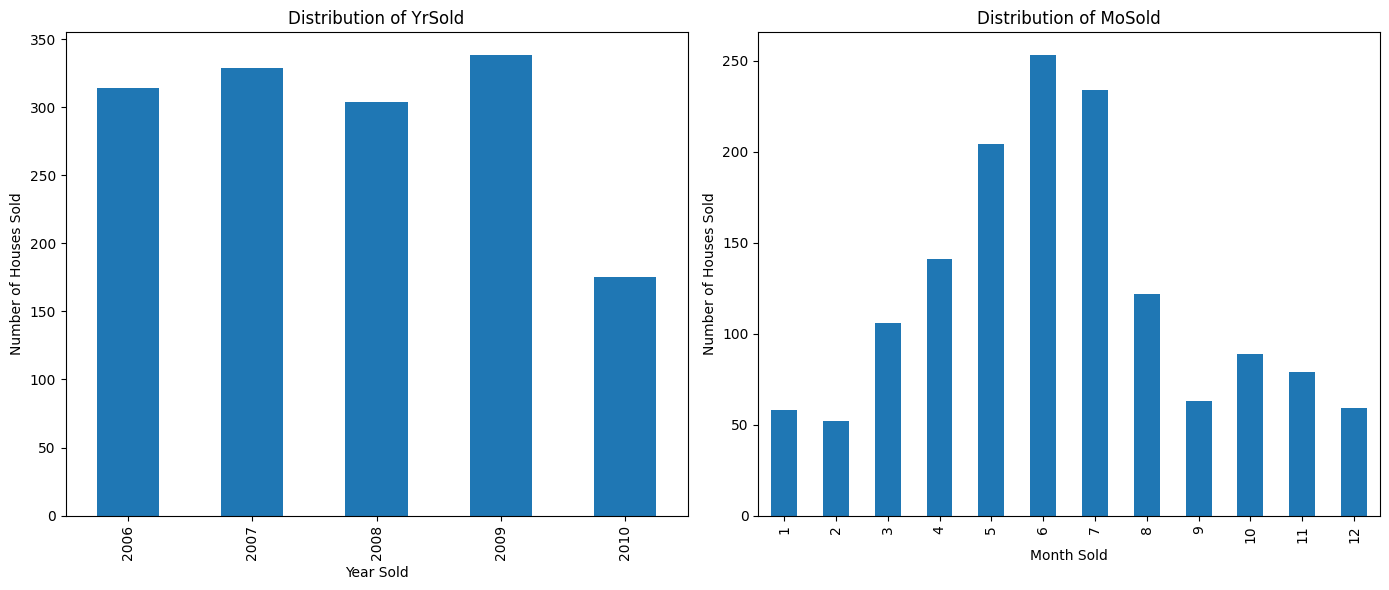

In [4]:
# Plot the distribution of YrSold and MoSold
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot YrSold distribution
df_train['YrSold'].value_counts().sort_index().plot(kind='bar', ax=ax[0])
ax[0].set_title('Distribution of YrSold')
ax[0].set_xlabel('Year Sold')
ax[0].set_ylabel('Number of Houses Sold')

# Plot MoSold distribution
df_train['MoSold'].value_counts().sort_index().plot(kind='bar', ax=ax[1])
ax[1].set_title('Distribution of MoSold')
ax[1].set_xlabel('Month Sold')
ax[1].set_ylabel('Number of Houses Sold')

plt.tight_layout()
plt.show()

In [5]:
target_column = "MoSold"

In [20]:
# 1
# Feature Selection
# Selecting relevant features based on market factors, house attributes, and location
# - Market Factors: SaleType, SaleCondition (Impact how houses are sold)
# - House Attributes: LotArea, MSSubClass, MSZoning, OverallQual, OverallCond (Impact desirability)
# - Location: Neighborhood, Condition1 (Affects price trends)
# - Temporal: YrSold (Historical trends)

# Feature Selection
selected_features = [
    "MSSubClass", "MSZoning", "LotArea", "OverallQual", "OverallCond",
    "Neighborhood", "Condition1", "SaleType", "SaleCondition", "YrSold"
]
# 2 We create lag 1 month and 3 month average
df_train = df_train[selected_features + [target_column]]
df_test = df_test[selected_features]  # No target column in test set

In [24]:

from sklearn.impute import SimpleImputer

# Handle Missing Data
numeric_features = ["MSSubClass", "LotArea", "OverallQual", "OverallCond", "YrSold"]
categorical_features = ["MSZoning", "Neighborhood", "Condition1", "SaleType", "SaleCondition"]

# Impute numeric features
numeric_imputer = SimpleImputer(strategy="mean")
df_train[numeric_features] = numeric_imputer.fit_transform(df_train[numeric_features])
df_test[numeric_features] = numeric_imputer.transform(df_test[numeric_features])

In [ ]:
# 3 Here we handle the missing values. Imputatation, Encoding with one hot, and scal .
# Impute categorical features
categorical_imputer = SimpleImputer(strategy="most_frequent")
df_train[categorical_features] = categorical_imputer.fit_transform(df_train[categorical_features])
df_test[categorical_features] = categorical_imputer.transform(df_test[categorical_features])

# Encode Categorical Features
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")
cat_encoded_train = encoder.fit_transform(df_train[categorical_features])
cat_encoded_test = encoder.transform(df_test[categorical_features])

cat_encoded_train_df = pd.DataFrame(cat_encoded_train, columns=encoder.get_feature_names_out(categorical_features))
cat_encoded_test_df = pd.DataFrame(cat_encoded_test, columns=encoder.get_feature_names_out(categorical_features))

In [27]:
# 2 Here the lag month are created
# Feature Engineering: Rolling Average & Lag Features (Only in df_train)
df_train["MoSold_Lag1"] = df_train["MoSold"].shift(1).fillna(df_train["MoSold"].mean())  # Lag-1 month
df_train["MoSold_Rolling3"] = df_train["MoSold"].rolling(window=3, min_periods=1).mean()  # 3-month avg

# Scaling (Separate for Train and Test)
scaler_train = StandardScaler()
num_scaled_train = scaler_train.fit_transform(df_train[numeric_features + ["MoSold_Lag1", "MoSold_Rolling3"]])
num_scaled_train_df = pd.DataFrame(num_scaled_train, columns=numeric_features + ["MoSold_Lag1", "MoSold_Rolling3"])

scaler_test = StandardScaler()
num_scaled_test = scaler_test.fit_transform(df_test[numeric_features])
num_scaled_test_df = pd.DataFrame(num_scaled_test, columns=numeric_features)

# Combine Processed Features
processed_train_df = pd.concat([num_scaled_train_df, cat_encoded_train_df, df_train[target_column].reset_index(drop=True)], axis=1)
processed_test_df = pd.concat([num_scaled_test_df, cat_encoded_test_df], axis=1)

In [28]:
# Train-Test Split
X = processed_train_df.drop(columns=[target_column]).values
y = processed_train_df[target_column].values - 1  # Convert months (1-12) to class indices (0-11)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert to PyTorch Tensors
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
X_val_torch = torch.tensor(X_val, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
y_val_torch = torch.tensor(y_val, dtype=torch.long).to(device)

In [15]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train_torch = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_torch = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_torch = torch.tensor(X_test, dtype=torch.float32).to(device)

In [69]:
# Define LSTM Model
class LSTMSalesPredictor(nn.Module):
    def __init__(self, input_size, hidden_size=32, num_layers=2, num_classes=12, dropout=0.3):
        super(LSTMSalesPredictor, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence dimension
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Get last time step output
        return out

# Initialize Model
input_size = X_train.shape[1]
model = LSTMSalesPredictor(input_size).to(device)


In [71]:
# Training Loop with Early Stopping and Learning Rate Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

num_epochs = 100  # Increase maximum epochs
patience = 10  # Allow more patience before stopping
best_val_loss = float("inf")
patience_counter = 0
best_model_state = None

train_losses, val_losses = [], []

for epoch in tqdm(range(num_epochs)):
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_torch)
    loss = criterion(y_pred, y_train_torch)
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_torch)
        val_loss = criterion(y_val_pred, y_val_torch)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())

    scheduler.step(val_loss)  # Reduce LR if needed

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        best_model_state = model.state_dict()  # Save best model
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

 14%|█▍        | 14/100 [00:00<00:01, 51.62it/s]

Early stopping triggered at epoch 14


Validation Accuracy: 0.1952054794520548
Classification Report:               precision    recall  f1-score   support

           1       0.00      0.00      0.00        17
           2       0.00      0.00      0.00        14
           3       0.20      0.36      0.25        22
           4       0.00      0.00      0.00        34
           5       0.15      0.38      0.22        26
           6       0.33      0.34      0.33        47
           7       0.20      0.39      0.26        46
           8       0.00      0.00      0.00        29
           9       0.00      0.00      0.00        14
          10       0.00      0.00      0.00        19
          11       0.11      0.45      0.18        11
          12       0.00      0.00      0.00        13

    accuracy                           0.20       292
   macro avg       0.08      0.16      0.10       292
weighted avg       0.12      0.20      0.14       292



c:\Users\nickl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nickl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\nickl\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

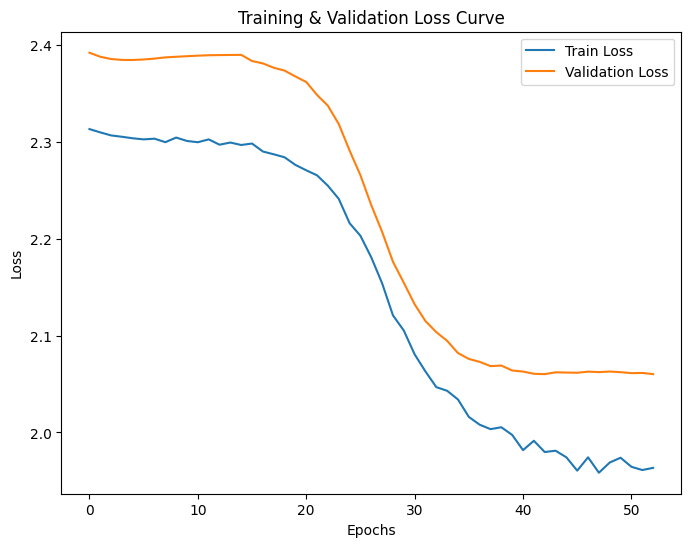

In [73]:
from sklearn.metrics import classification_report

# Evaluation
with torch.no_grad():
    y_val_pred = model(X_val_torch).detach().cpu().numpy()
    y_val_pred_classes = np.argmax(y_val_pred, axis=1) + 1

# Accuracy and Classification Report
print("Validation Accuracy:", accuracy_score(y_val + 1, y_val_pred_classes))
print("Classification Report:", classification_report(y_val + 1, y_val_pred_classes))

# Plot Training & Validation Losses
plt.figure(figsize=(8, 6))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curve")
plt.legend()
plt.show()